<a href="https://colab.research.google.com/github/rkambai/kaggle-russian-sales-predict/blob/main/kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir("/content/drive/MyDrive/kaggle/")

In [3]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import statistics

import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers
from tensorflow.keras import callbacks

from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.model_selection import train_test_split

In [4]:
train, test, items, item_cat, shops, sample = pd.read_csv("sales_train.csv"), pd.read_csv("test.csv"),pd.read_csv("items.csv"), pd.read_csv("item_categories.csv"),pd.read_csv("shops.csv"),pd.read_csv('sample_submission.csv')

Some shops have repeated entries, change them to constant value and then dropping duplicate rows

In [5]:
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

In [6]:
train.drop_duplicates(inplace=True)

Define function to split date column into 3 new columns -> day, month, year

In [7]:
def timesplit(df, separator): ## separator is what separates day, month and year syntactically
    df['Year']=[d.split(separator)[2] for d in df.date]
    df['Year'] = df['Year'].astype(int)
    df['Month']=[d.split(separator)[1] for d in df.date]
    df['Month'] = df['Month'].astype(int)
    df['Day']=[d.split(separator)[0] for d in df.date]
    df['Day'] = df['Day'].astype(int)

In [8]:
timesplit(train,".")

Merging of dataframes

In [9]:
item_merge = pd.merge(items,item_cat,how='left',on='item_category_id')

In [10]:
merged = pd.merge(train, shops, how='left', on='shop_id')

In [11]:
merged = pd.merge(merged, item_merge, how='left',on='item_id')


removing outliers

In [12]:
merged.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,Year,Month,Day,item_category_id
count,2.935843e+06,2.935843e+06,2.935843e+06,2.935843e+06,2.935843e+06,2.935843e+06,2.935843e+06,2.935843e+06,2.935843e+06
mean,1.456991e+01,3.331062e+01,1.019723e+04,8.908535e+02,1.242641e+00,2.013777e+03,6.247719e+00,1.585267e+01,4.000141e+01
std,9.422992e+00,1.613680e+01,6.324293e+03,1.729801e+03,2.618837e+00,7.684796e-01,3.536219e+00,8.923479e+00,1.710076e+01
min,0.000000e+00,2.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01,2.013000e+03,1.000000e+00,1.000000e+00,0.000000e+00
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00,2.013000e+03,3.000000e+00,8.000000e+00,2.800000e+01
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00,2.014000e+03,6.000000e+00,1.600000e+01,4.000000e+01
75%,2.300000e+01,4.800000e+01,1.568400e+04,9.990000e+02,1.000000e+00,2.014000e+03,9.000000e+00,2.400000e+01,5.500000e+01
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03,2.015000e+03,1.200000e+01,3.100000e+01,8.300000e+01


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


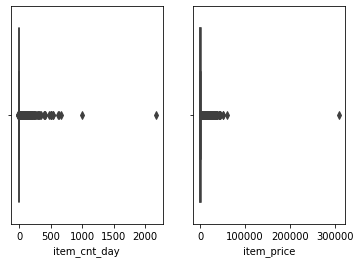

In [18]:
f, axes = plt.subplots(1,2)
axes[0] = sb.boxplot(merged.item_cnt_day, ax=axes[0])
axes[1] = sb.boxplot(merged.item_price, ax=axes[1])

In [19]:
condition = ((merged['item_cnt_day']>0)&(merged['item_cnt_day']<1000) & (merged['item_price']<100000) & (merged['item_price']>0))

df = merged[condition]

Replacing prices in the dataframe with median price found for each item to account for differences in item prices over time. 

In [25]:
df.loc[df['item_id'] == 2552].head(n=2) ## For example, item 2552 has different prices for these shops

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,Year,Month,Day,shop_name,item_name,item_category_id,item_category_name
1,03.01.2013,0,25,2552,899.0,1.0,2013,1,3,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
375823,25.04.2013,3,6,2552,949.0,1.0,2013,4,25,"Воронеж (Плехановская, 13)",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил


In [28]:
prices = (pd.DataFrame(df.groupby(by=['item_id']).median()))

In [30]:
prices = prices.iloc[:,[2]]

In [31]:
prices.reset_index(inplace=True)

In [32]:
df2 = pd.merge(df,prices,on='item_id',how='left')

In [33]:
df2.drop(columns='item_price_x',inplace=True)
df2.rename(columns={'item_price_y':'item_price'},inplace=True)

Grouping rows to get item count per month, by=list in order to isolate the label 

In [34]:
grp = pd.DataFrame((df2.groupby(by=['Year','Month','date_block_num','shop_id','shop_name','item_id','item_name','item_category_id','item_category_name','item_price'])).sum())

In [35]:
grp.drop(columns = ['Day'], inplace=True)

In [36]:
grp.reset_index(inplace=True)

In [37]:
grp.rename(columns={"item_cnt_day":"item_cnt_month"},inplace=True)

clipping values from [0,20]

In [38]:
grp.loc[grp['item_cnt_month']>20,['item_cnt_month']] = 20

In [39]:
grp.loc[grp['item_cnt_month']<0, ['item_cnt_month']] = 0

In [41]:
print(grp.item_cnt_month.max(), grp.item_cnt_month.min())

20.0 1.0


Creating columnz containing mean price of each item's assigned category, and the ratio of each item's price against the category mean.

In [42]:
prices_cat = pd.merge(item_merge, prices, on='item_id',how='left').drop(columns=['item_name','item_category_name','item_id'])

In [43]:
prices_cat = prices_cat.groupby(by='item_category_id').mean()

In [44]:
prices_cat.rename(columns={'item_price':'cat_mean'},inplace=True)

In [45]:
grp = pd.merge(grp,prices_cat,on='item_category_id',how='left')

In [46]:
grp['price_ratio'] = grp['item_price']/grp['cat_mean']

In [47]:
grp.head()

,Year,Month,date_block_num,shop_id,shop_name,item_id,item_name,item_category_id,item_category_name,item_price,item_cnt_month,cat_mean,price_ratio
0,2013,1,0,2,"Адыгея ТЦ ""Мега""",27,"007 Legends [PS3, русская версия]",19,Игры - PS3,1398.0,1.0,1420.083504,0.984449
1,2013,1,0,2,"Адыгея ТЦ ""Мега""",33,1+1 (BD),37,Кино - Blu-Ray,199.0,1.0,385.057106,0.516806
2,2013,1,0,2,"Адыгея ТЦ ""Мега""",317,1С:Аудиокниги. Мединский В. Мифы о России. О р...,45,Книги - Аудиокниги 1С,299.0,1.0,254.854545,1.173218
3,2013,1,0,2,"Адыгея ТЦ ""Мега""",438,1С:Аудиотеатр. Лучшие произведения русских пис...,45,Книги - Аудиокниги 1С,299.0,1.0,254.854545,1.173218
4,2013,1,0,2,"Адыгея ТЦ ""Мега""",471,1С:Бухгалтерия 8 (ред.3.0) как на ладони. Изд ...,49,Книги - Методические материалы 1С,399.0,2.0,446.543210,0.893531


Create columns based on total of each item sold for each shops and average number sold per month

In [48]:
roll = (grp.groupby(by=['shop_id','item_id'])).sum()

In [49]:
roll.rename(columns={"item_cnt_month":"total_sales"},inplace=True)

In [50]:
roll = roll[['total_sales']]

In [51]:
roll.reset_index(inplace=True)

In [52]:
total = pd.merge(grp,roll,on=['shop_id','item_id'])

In [53]:
total['avg_month'] = total['total_sales']/(total['date_block_num'].max())

In [54]:
total['sales_ratio'] = total['item_cnt_month']/total['total_sales']

In [55]:
total.head()

,Year,Month,date_block_num,shop_id,shop_name,item_id,item_name,item_category_id,item_category_name,item_price,item_cnt_month,cat_mean,price_ratio,total_sales,avg_month,sales_ratio
0,2013,1,0,2,"Адыгея ТЦ ""Мега""",27,"007 Legends [PS3, русская версия]",19,Игры - PS3,1398.0,1.0,1420.083504,0.984449,2.0,0.060606,0.500000
1,2014,6,17,2,"Адыгея ТЦ ""Мега""",27,"007 Legends [PS3, русская версия]",19,Игры - PS3,1398.0,1.0,1420.083504,0.984449,2.0,0.060606,0.500000
2,2013,1,0,2,"Адыгея ТЦ ""Мега""",33,1+1 (BD),37,Кино - Blu-Ray,199.0,1.0,385.057106,0.516806,11.0,0.333333,0.090909
3,2013,11,10,2,"Адыгея ТЦ ""Мега""",33,1+1 (BD),37,Кино - Blu-Ray,199.0,2.0,385.057106,0.516806,11.0,0.333333,0.181818
4,2013,12,11,2,"Адыгея ТЦ ""Мега""",33,1+1 (BD),37,Кино - Blu-Ray,199.0,1.0,385.057106,0.516806,11.0,0.333333,0.090909


Fixing test data

In [ ]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [56]:
m1 = pd.merge(test, shops, on = 'shop_id', how = 'left')

In [57]:
m2 = pd.merge(m1, item_merge, on = 'item_id', how = 'left')

In [67]:
m3 = pd.merge(m2,prices,on='item_id',how='left')

In [69]:
m3['Month'] = 11
m3['Year'] = 2015
m3['date_block_num'] = 34

There are some NaN values in item_price due to these items being absent in the train set, perhaps these items have never been sold at all or are new. Replace NaN values with category mean.

In [70]:
m3 = pd.merge(m3,prices_cat,on='item_category_id',how='left')

In [71]:
block = m3.loc[m3['item_price'].isna(), ['item_price','cat_mean']] 

In [72]:
m3.loc[m3['item_price'].isna(),['item_price']] = block['cat_mean']

In [73]:
m3['price_ratio'] = m3['item_price']/m3['cat_mean']

############################################

START OF TF NN TRIAL

Note: The target used for this trial was avg_month instead of directly using item_cnt_month, which yielded an rmse of 1.32146 on the hidden test set on Kaggle. 

The reason for this was because item_cnt_month though convenient, may have caused bias in the model as the train data only contained rows where sales have been made. Thus, occasions where there were no sales at all were omitted, which may result in item_cnt_month predicted values being higher than expected. Thus, avg_month was created to give a better representation of the sales of each item in each shop overall.

Indeed, using avg_month attained a better score than item_cnt_month, thus will be sticking to that target value.

######################################

In [91]:
train_df,test_df = train_test_split(total,test_size = 0.2,random_state = 123)
train_df.shape, test_df.shape

((1286579, 16), (321645, 16))

In [76]:
def create_model(my_learning_rate, my_feature_layer):
    """Create and compile a simple linear regression model."""

    # Discard any pre-existing version of the model.
    model = None

    # Most simple tf.keras models are sequential.
    model = tf.keras.models.Sequential()

    # Add the layer containing the feature columns to the model.
    model.add(my_feature_layer)

    # Describe the topography of the model. 

    # Implement L2 regularization in the first hidden layer.
    model.add(tf.keras.layers.Dense(units=20, 
                                  activation='relu',
                                  kernel_regularizer=tf.keras.regularizers.l2(0.01),
                                  name='Hidden1'))

    # Implement L2 regularization in the second hidden layer.
    model.add(tf.keras.layers.Dense(units=20, 
                                  activation='relu', 
                                  kernel_regularizer=tf.keras.regularizers.l2(0.01),
                                  name='Hidden2'))
    

    # Define the output layer.
    model.add(tf.keras.layers.Dense(units=1,  
                                  name='Output'))                              

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.MeanSquaredError()])

    return model     

def train_model(model, dataset, epochs, label_name, callback,
                batch_size=None):
    """Train the model by feeding it data."""

    # Split the dataset into features and label.
    features = {name:np.array(value) for name, value in dataset.items()}
    label = np.array(features.pop(label_name))
    history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, callbacks=[callback], shuffle=True) 

    # The list of epochs is stored separately from the rest of history.
    epochs = history.epoch

    # To track the progression of training, gather a snapshot
    # of the model's mean squared error at each epoch. 
    hist = pd.DataFrame(history.history)
    mse = hist["mean_squared_error"]

    return epochs, mse

# Call the new create_model function and the other (unchanged) functions.

# The following variables are the hyperparameters.



'\nlearning_rate = 0.007\nepochs = 140\nbatch_size = 1000\n\nlabel_name = "median_house_value"\n\n# Establish the model\'s topography.\nmy_model = create_model(learning_rate, my_feature_layer)\n\n# Train the model on the normalized training set.\nepochs, mse = train_model(my_model, train_df_norm, epochs, \n                          label_name, batch_size)\nplot_the_loss_curve(epochs, mse)\n\ntest_features = {name:np.array(value) for name, value in test_df_norm.items()}\ntest_label = np.array(test_features.pop(label_name)) # isolate the label\nprint("\n Evaluate the new model against the test set:")\nmy_model.evaluate(x = test_features, y = test_label, batch_size=batch_size) '

In [93]:
feature_columns = []

to_num = ['Year','Month','date_block_num','shop_id','item_id','item_category_id','item_price','cat_mean','price_ratio']
target = "avg_month"
to_cat = ["shop_name", "item_name", "item_category_name"]

for num in to_num:
  add = tf.feature_column.numeric_column(num)
  feature_columns.append(add)

for cat in to_cat:
  vector = feature_column.categorical_column_with_vocabulary_list(cat, grp[cat].unique())
  vector_embedding = feature_column.embedding_column(vector, dimension=12)
  feature_columns.append(vector_embedding)


# Convert the list of feature columns into a layer that will later be fed into
# the model. 
feature_layer = layers.DenseFeatures(feature_columns)



In [94]:
def plot_the_loss_curve(epochs, mse):
    """Plot a curve of loss vs. epoch."""

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Mean Squared Error")

    plt.plot(epochs, mse, label="Loss")
    plt.legend()
    plt.ylim([mse.min()*0.95, mse.max() * 0.0001])
    plt.show()  

print("Defined the plot_the_loss_curve function.")

Defined the plot_the_loss_curve function.


Epoch 1/100
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
1287/1287 [==============================] - 82s 62ms/step - loss: 7861.7344 - mean_squared_error: 7861.2725
Epoch 2/100
1287/1287 [==============================] - 82s 64ms/step - loss: 101.0716 - mean_squared_error: 100.6360
Epoch 3/100
1287/1287 [==============================] - 80s 62ms/step - loss: 35.1247 - mean_squared_error: 34.6985
Epoch 4/100
1287/1287 [==============================] - 84s 65ms/step - loss: 20.7314 - mean_squared_error: 20.3127
Epoch 5/100
1287/1287 [==============================] - 83s 65ms/step - loss: 14.1992 - mean_squared_error: 13.7842
Epoch 6/100
1287/1287 [==============================] - 84s 65ms/step - loss: 10.0868 - mean_squared_error: 9.6677
Epoch 7/100
1287/1287 [==============================] - 83s 64ms/step - loss: 7.3144 - mean_squared_error: 6.8852
Epoch 8/100
1287/1287 [==============================] - 83s 64ms/st

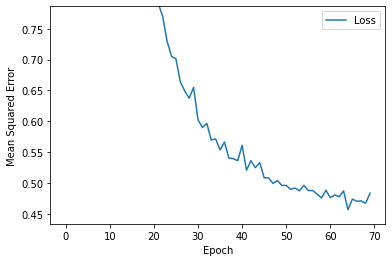


 Evaluate the new model against the test set:
Consider rewriting this model with the Functional API.
322/322 [==============================] - 6s 17ms/step - loss: 0.6511 - mean_squared_error: 0.4489


[0.6510956287384033, 0.4488849341869354]

In [103]:
learning_rate = 0.0001
epochs = 100
batch_size = 1000
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, mode='min')

label_name = "avg_month"

# Establish the model's topography.
my_model = create_model(learning_rate, feature_layer)

# Train the model on the normalized training set.
epochs, mse = train_model(my_model, train_df, epochs, label_name, callback, batch_size)
plot_the_loss_curve(epochs,mse)
test_features = {name:np.array(value) for name, value in test_df.items()}
test_label = np.array(test_features.pop(label_name)) # isolate the label
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size)

In [104]:
final_test = {name:np.array(value) for name, value in m3.items()}

In [105]:
submit = pd.DataFrame(data = my_model.predict(x=final_test), columns=['item_cnt_month'])

Consider rewriting this model with the Functional API.


In [106]:
submit.loc[(submit['item_cnt_month']<=0),['item_cnt_month']] = 0

In [107]:
submit.reset_index(inplace=True)
submit.rename(columns={"index":"ID"}, inplace=True)

In [108]:
submit

,ID,item_cnt_month
0,0,0.767626
1,1,0.384002
2,2,0.258020
3,3,0.000000
4,4,3.642047
...,...,...
214195,214195,0.197463
214196,214196,0.076539
214197,214197,0.119782
214198,214198,0.000000


In [110]:
#submit.to_csv("submission.csv", index=False)

END OF TF NN TRIAL

########################################

XGBOOST trial

Note: Lineup and shape of data and features must be same in both train and test sets, as well as when using predict.

Target value will be avg_month for this trial as well. An rmse of 1.31999 was attained on Kaggle, a slight improvement from the TensorFlow model.

###############################################

In [77]:
d = total.copy()

In [78]:
d = d[['date_block_num','Month','Year','shop_id','item_id','item_price','item_category_id','cat_mean','price_ratio','avg_month']]

In [79]:
import xgboost as xgb

In [80]:
train_df,test_df = train_test_split(d, test_size=0.2, random_state=123)

In [81]:
xgtrain = train_df.drop(columns='avg_month')

In [82]:
label = train_df['avg_month']

In [83]:
dtrain = xgb.DMatrix(xgtrain, label=label)

In [84]:
xgtest = test_df.drop(columns='avg_month')

In [85]:
dtest = xgb.DMatrix(xgtest, label=test_df['avg_month'])

In [86]:
params = {'max_depth':8,'eta':0.1,'lambda':0.2,'eval_metric':'rmse'}

In [87]:
evallist = [(dtest, 'eval'), (dtrain, 'train')]

In [ ]:
num_round=500
model = xgb.train(params,dtrain,num_round,evallist, early_stopping_rounds=5)

In [89]:
testdata = m3[['date_block_num','Month','Year','shop_id','item_id','item_price','item_category_id','cat_mean','price_ratio']]

In [ ]:
final = xgb.DMatrix(testdata)

In [ ]:
predicted = model.predict(final)

In [ ]:
submit = pd.DataFrame(data=predicted, columns = ['item_cnt_month'])

In [ ]:
submit.loc[submit['item_cnt_month']<=0,['item_cnt_month']] = 0
submit.loc[submit['item_cnt_month']>20,['item_cnt_month']] = 20

In [ ]:
model.get_score(importance_type='weight')

{'Month': 758,
 'cat_mean': 2574,
 'date_block_num': 8377,
 'item_category_id': 6160,
 'item_id': 31903,
 'item_price': 8569,
 'price_ratio': 7646,
 'shop_id': 43682}

In [ ]:
#(submit.reset_index().rename(columns={'index':'ID'})).to_csv('submission.csv',index=False)

Rmse values could have possible been improved by tuning the hyperparameters of both models, as well as tweaking regularization rates. The chosen hyperparameters were mainly fixed based on how much patience I had.